In [1]:
import sys
sys.path.append('/scratch/anaconda3/lib/python3.6/site-packages')
sys.path.append('/scratch/michael_git/indic_nlp_library/src')

import pandas as pd
import re
import glob
import numpy as np
import scipy.stats
from scipy import stats
import matplotlib.pyplot as plt
import sentencepiece as spm
import sacrebleu
pd.__version__

'0.24.2'

In [4]:
def readTSV(path):
    return pd.read_csv(path, sep='\t', low_memory=False)

def processFlowName(f):
    num_flows = f.split('_with_')[-1].split('_flows_')[0]
    num_flows = int(num_flows)
    
    langs = f.split('/')[-1].split('_trainslation_')[0].split('_to_')
    src = langs[0]
    trg = langs[1]
    return src, trg, num_flows

def DecodeBPE(model, sentences):
    detokenized = []
    #takes in a single column Pandas data frame
    sentences = sentences.values.tolist()
    for line in sentences:
        line = model.DecodePieces(line.strip().split()) 
       
        detokenized.append(line)
    return detokenized

def loadBPEModel(m):
    sp = spm.SentencePieceProcessor()
    sp.Load(m + '.model')
    return sp

def CalculateBleus(directory, source, target, model_name):
    files = glob.glob(directory + source + '_to_'+ target + '*.tsv')
    BPE = loadBPEModel(model_name)
    
    results ={}
    for f in files:
        src, trg, num_flows = processFlowName(f)
        translation = readTSV(f)
        hypothesis = translation['Hypothesis']
        hypothesis = DecodeBPE(BPE, hypothesis)
        reference = translation['Reference']
        reference = DecodeBPE(BPE, reference)
        BLEU = sacrebleu.raw_corpus_bleu(hypothesis, [reference])
        results[num_flows] = BLEU.score
        
    return results
        

In [6]:
ar_results = CalculateBleus('./translations/', 'ar', 'en', './bpe_models/ar_english')
results = pd.DataFrame.from_dict(ar_results, orient='index').sort_index()
results

,0
0,12.373473
1,12.261403
2,12.124277
4,12.110422
8,12.023514
16,11.725176
32,11.600805


In [7]:
de_results = CalculateBleus('./translations/', 'de', 'en', './bpe_models/de_english')
results = pd.DataFrame.from_dict(de_results, orient='index').sort_index()
results

,0
0,19.739131
1,20.768485
2,19.902206
4,19.801080
8,19.426371
16,18.762436
32,19.881187


In [71]:
all_results = {}
all_results['ar_en'] = ar_results
all_results['de_en'] =de_results

pd.DataFrame.from_dict(all_results, orient='columns').sort_index()

ValueError: If using all scalar values, you must pass an index

In [2]:
def readTSV(path):
    return pd.read_csv(path, sep='\t', low_memory=False)

def GetAllResults(flow_type, l1, l2):
    print('./{}_num_flows_*_{}_{}_model_BLEU_scores.tsv'.format(flow_type, l1, l2,))
    files = glob.glob('./{}_num_flows_*_{}_{}_model_BLEU_scores.tsv'.format(flow_type, l1, l2,))
    best_results = {}
    for f in files:
        best = -1.0
        model_results = readTSV(f)
        epoch = "empty"
        for i in model_results:
            if best < model_results[i].to_numpy()[0]:
                best = model_results[i].to_numpy()[0]
                epoch = i
            
            #best = model_results[i].to_numpy()[0] if best < model_results[i].to_numpy()[0] else best
            
        name = f.split('flows_')[-1].split('_')[0]
        best_results[int(name)] = {"bleu": best, "epoch": epoch}
    return best_results

In [3]:
#IAF flows
iaf_results = GetAllResults('iaf', 'de', 'en')
pd.DataFrame.from_dict(iaf_results,'index').sort_index()

./iaf_num_flows_*_de_en_model_BLEU_scores.tsv


,bleu,epoch
0,19.851707,epoch_8
1,19.668123,epoch_9
2,19.266370,epoch_9
4,17.681535,epoch_6
8,19.992849,epoch_9
16,18.012046,epoch_6
32,19.943787,epoch_9


In [4]:
#Planar flows
planar_results = GetAllResults('planar', 'de', 'en')
pd.DataFrame.from_dict(planar_results,'index').sort_index()

./planar_num_flows_*_de_en_model_BLEU_scores.tsv


,bleu,epoch
0,19.509695,epoch_8
1,20.179916,epoch_9
2,20.171053,epoch_9
4,19.728739,epoch_9
8,20.042038,epoch_8
16,19.107872,epoch_8
32,18.999040,epoch_9


In [5]:
def getValues(results):
    values = sorted([[item[0], item[1]['bleu']] for item in results.items()], key=lambda x: x[0])
    xy = np.array(values)
    #plot flows
    x = np.log2(xy[:,0][1:])
    #print(x)
    #x = xy[:,0][1:]
    y = xy[:,1][1:]
    no_flow = [xy[0,1] for _ in range(6)]
    #print(no_flow)
    #xs_no_flow = [i for i in range(6)]
    xs_no_flow = x
    #print(xs_no_flow)

    
    #print(x)
    #print(y)
    return xs_no_flow, no_flow, x, y


[19.6681225  19.26636977 17.68153465 19.99284879 18.01204635 19.9437867 ]
[20.17991642 20.17105262 19.72873871 20.04203778 19.10787168 18.99903959]


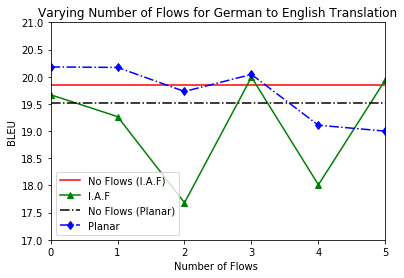

In [7]:
#IAF FLows

xs_no_flow, no_flow, x, y = getValues(iaf_results)
plt.plot(xs_no_flow, no_flow , 'r-', label='No Flows (I.A.F)')
plt.plot(x, y, 'g^-', label='I.A.F')

print(y)
#Planar Flows
xs_no_flow, no_flow, x, y = getValues(planar_results)
print(y)
plt.plot(xs_no_flow, no_flow , 'k-.', label='No Flows (Planar)')
plt.plot(x, y, 'bd-.', label='Planar')


plt.axis([0, max(x), 17, 21 ])

plt.xticks(x)
plt.ylabel("BLEU")
plt.xlabel("Number of Flows ")
plt.title("Varying Number of Flows for German to English Translation")
plt.legend()
plt.savefig('generalBLEUscore.pdf', format='pdf')
plt.show()

[[ 0.         19.59986035]
 [ 1.         19.29968194]
 [ 2.         19.35218886]
 [ 4.         18.99434598]
 [ 8.         19.20580534]
 [16.         17.64337639]
 [32.         19.66655449]]
[19.599860347602032, 19.599860347602032, 19.599860347602032, 19.599860347602032, 19.599860347602032, 19.599860347602032]
[0, 1, 2, 3, 4, 5]
[0. 1. 2. 3. 4. 5.]
[0. 1. 2. 3. 4. 5.]
[19.29968194 19.35218886 18.99434598 19.20580534 17.64337639 19.66655449]


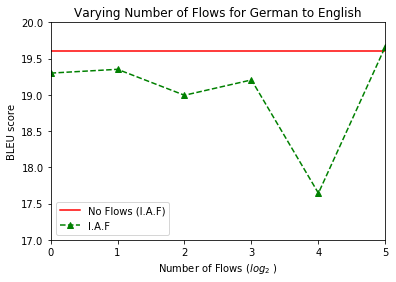

In [113]:
import matplotlib.pyplot as plt

values = sorted([[item[0], item[1]['bleu']] for item in best_results.items()], key=lambda x: x[0])
xy = np.array(values)
print(xy)
#Plot no flows
no_flow = [xy[0,1] for _ in range(6)]
print(no_flow)
xs_no_flow = [i for i in range(6)]
print(xs_no_flow)


plt.plot(xs_no_flow, no_flow , 'r-', label='No Flows (I.A.F)')


#plot flows
x = np.log2(xy[:,0][1:])
print(x)
y = xy[:,1][1:]
print(x)
print(y)
plt.plot(x, y, 'g^--', label='I.A.F')
plt.axis([0, 5, 17 , 20 ])

plt.xticks(x)

plt.ylabel("BLEU score")
plt.xlabel("Number of Flows ($log_{2}$ ) ")
plt.title("Varying Number of Flows for German to English Translation")
plt.legend()
plt.show()
plt.savefit('')